In [74]:
import os
import numpy as np
from matplotlib import pyplot as plt
from ase.units import _e, _hplanck, kB
from numpy.linalg import lstsq

G0 = 2. * _e**2 / _hplanck
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl/production_run'
os.chdir(new_path)

In [75]:
def fermidistribution(energy, kt):
    # fermi level is fixed to zero
    # energy can be a single number or a list
    assert kt >= 0., 'Negative temperature encountered!'

    if kt == 0:
        if isinstance(energy, float):
            return int(energy / 2. <= 0)
        else:
            return (energy / 2. <= 0).astype(int)
    else:
        return 1. / (1. + np.exp(energy / kt))


def current(bias, energy, transmission, temperature=300, unit='uA',shift=0.0):
    """Get the current in uA."""
    if not isinstance(bias, (int, float)):
        bias = bias[np.newaxis]
        energy = energy[:, np.newaxis]
        transmission = transmission[:, np.newaxis]

    fl = fermidistribution(energy - bias / 2., kB * temperature)
    fr = fermidistribution(energy + bias / 2., kB * temperature)
    return G0 * np.trapz((fl - fr) * transmission, x=energy, axis=0) * 1e6, fl, fr  # uA


def fit_cubic_zero_intercept(bias: np.ndarray, current: np.ndarray) -> np.ndarray:
    """
    Fit a cubic polynomial to I–V data with the constraint that the intercept is zero.

    This function solves the least squares problem for a cubic polynomial of the form:

        I(V) = a₃·V³ + a₂·V² + a₁·V

    where:
    - `I(V)` is the current as a function of voltage `V` (bias),
    - The constant (bias-independent) term is explicitly excluded to enforce I(0) = 0.

    The fit is performed by constructing a design matrix `X`:
        X = [V³, V², V]

    and solving the linear system:
        X · c = I

    where:
    - `c = [a₃, a₂, a₁]ᵀ` are the polynomial coefficients,
    - `I` is the measured current at each bias point.

    Parameters
    ----------
    bias : np.ndarray
        1D array of voltage bias values.
    current : np.ndarray
        1D array of current values corresponding to each bias point.

    Returns
    -------
    coeffs : np.ndarray
        Array of coefficients [a₃, a₂, a₁] for the constrained cubic fit.

    Notes
    -----
    - This is a constrained fit where the zero-bias current is forced to be zero.
    """
    X = np.column_stack([bias**3, bias**2, bias])
    coeffs = lstsq(X, current, rcond=None)[0]
    return coeffs


In [76]:
temp = 11.6
kt = kB*temp
dV = 0.01
Vmin = 0
Vmax = 2
bias = np.arange(Vmin, Vmax + dV / 2., dV)
I_trieste_dft = np.load("../Angelo_data/dft/Jbias_landauer.npy")
I_trieste_dmft = np.load("../Angelo_data/dmft/Jbias_landauer.npy")
I_trieste_spin = np.load("../Angelo_data/dmft-spin/Jbias_landauer.npy")
E_dft,T_dft = np.load("./output/lowdin/dft/ET.npy")
E_dmft,T_dmft = np.load("./output/lowdin/dmft/non_spin/ET.npy")
_,T_dmft_up = np.load("./output/lowdin/dmft/spin/ET_up.npy")
_,T_dmft_down = np.load("./output/lowdin/dmft/spin/ET_dw.npy")
E_ed, T_ed = np.load("./output/lowdin/ed/ET.npy")


### DFT

/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

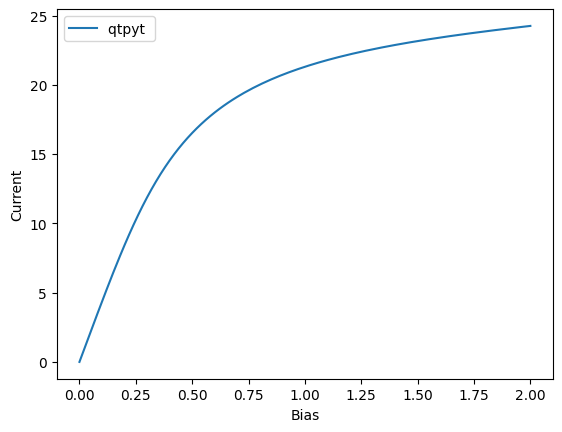

In [77]:
I_qtpyt_dft, _, _ = current(bias, E_dft, T_dft, temperature=temp)
# plt.plot(I_trieste_dft[0,:,0],-1*I_trieste_dft[0,:,1]*0.4*1e6,label="trieste from file X 0.4e6")
plt.plot(bias,I_qtpyt_dft,label="qtpyt ")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
# plt.xlim(0,0.1)
# plt.yscale("log")

coeffs [-36.70334453   0.13339812  43.88674205]


/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


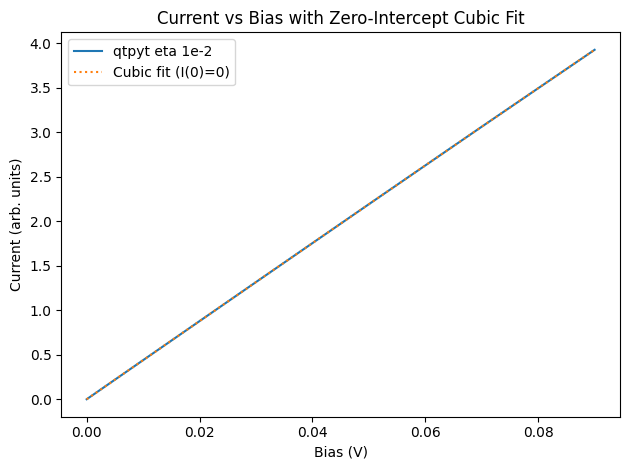

In [78]:
bias_coeff = np.arange(0.0, 0.1, 0.01) # Region for cubic fit
# bias_coeff = np.arange(0.1, 2.0, 0.01) # Region for ~ linear fit
I_dft_coeff, _, _ = current(bias_coeff, E_dft, T_dft, temperature=temp)

coeffs_cubic_constrained = fit_cubic_zero_intercept(bias_coeff, I_dft_coeff)
print("coeffs",coeffs_cubic_constrained)
I_fit_constrained = bias_coeff**3 * coeffs_cubic_constrained[0] + \
                    bias_coeff**2 * coeffs_cubic_constrained[1] + \
                    bias_coeff    * coeffs_cubic_constrained[2]

plt.plot(bias_coeff, I_dft_coeff, label="qtpyt eta 1e-2")
plt.plot(bias_coeff, I_fit_constrained, ':', label="Cubic fit (I(0)=0)")
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias with Zero-Intercept Cubic Fit")
plt.legend()
plt.tight_layout()
plt.show()


In [79]:
# Bias endpoints to try
# bias_endpoints = [0.001, 0.002, 0.003, 0.004, 0.005, 0.008, 0.01, 0.05, 0.1] # Region for cubic fit
bias_endpoints = [0.2, 2.0] # Region for linear fit

# Store rows of results
results = []

for endpoint in bias_endpoints:
    # bias = np.arange(0, endpoint + 1e-9, 0.001)  # include endpoint, region for cubic fit
    bias = np.arange(0.1, endpoint + 1e-9, 0.001)  # include endpoint, region for linear fit
    I_qtpyt, _, _ = current(bias, E_dft, T_dft, temperature=temp)
    coeffs = fit_cubic_zero_intercept(bias, I_qtpyt)
    a3, a2, a1 = coeffs
    sum_abs = abs(a3) + abs(a2) + abs(a1)

    w_cubic = abs(a3) / sum_abs * 100
    w_quad = abs(a2) / sum_abs * 100
    w_linear = abs(a1) / sum_abs * 100

    results.append([
        f"{endpoint:.3f}", f"{a3:.4e}", f"{a2:.4e}", f"{a1:.4e}",
        f"{w_cubic:.2f}%", f"{w_quad:.2f}%", f"{w_linear:.2f}%"
    ])


headers = [
    "Bias End", "a₃ (V³)", "a₂ (V²)", "a₁ (V)",
    "Cubic %", "Quad %", "Linear %"
]

print(f"{'Bias End':>8} | {'a₃ (V³)':>12} | {'a₂ (V²)':>12} | {'a₁ (V)':>12} | {'Cubic %':>8} | {'Quad %':>8} | {'Linear %':>9}")
for row in results:
    print(f"{row[0]:>8} | {row[1]:>12} | {row[2]:>12} | {row[3]:>12} | {row[4]:>8} | {row[5]:>8} | {row[6]:>9}")


Bias End |      a₃ (V³) |      a₂ (V²) |       a₁ (V) |  Cubic % |   Quad % |  Linear %
   0.200 |  -6.1982e+01 |   1.1157e+00 |   4.4242e+01 |   57.74% |    1.04% |    41.22%
   2.000 |   8.0217e+00 |  -3.3223e+01 |   4.6967e+01 |    9.09% |   37.66% |    53.24%


/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


### DMFT

/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

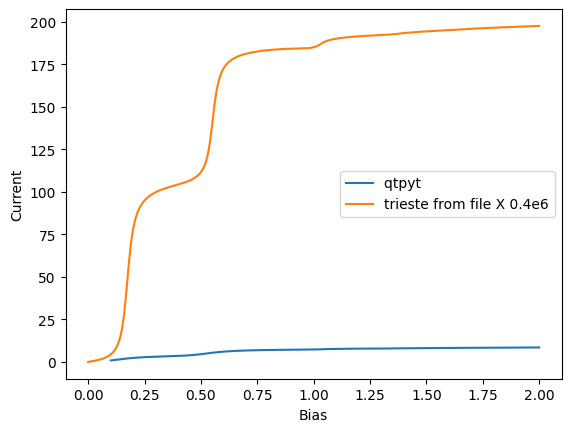

In [80]:
I_qtpyt_dmft, _, _ = current(bias, E_dmft, T_dmft, temperature=temp)
plt.plot(bias,I_qtpyt_dmft,label="qtpyt ")
plt.plot(I_trieste_dmft[0,:,0],-1*I_trieste_dmft[0,:,1]*0.4*1e6,label="trieste from file X 0.4e6")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
# plt.xlim(0,0.1)
# plt.yscale("log")

coeffs [303.63759817  -0.55179649   5.73325952]


/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


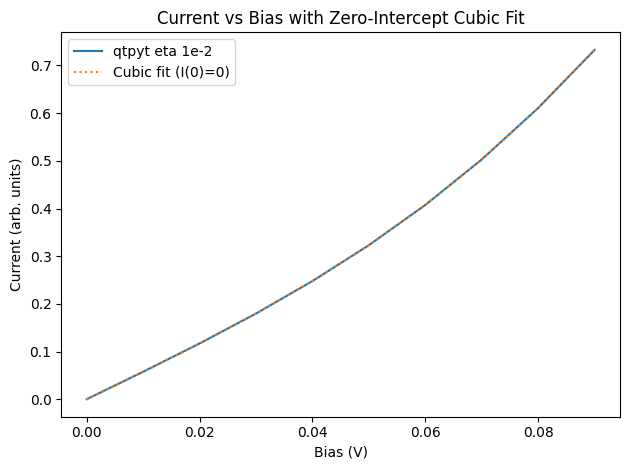

In [81]:
# bias_coeff = np.arange(0.0, 1.25, 0.01) # Region for linear fit
I_dmft_coeff, _, _ = current(bias_coeff, E_dmft, T_dmft, temperature=temp)

coeffs_cubic_constrained = fit_cubic_zero_intercept(bias_coeff, I_dmft_coeff)
print("coeffs",coeffs_cubic_constrained)
I_fit_constrained = bias_coeff**3 * coeffs_cubic_constrained[0] + \
                    bias_coeff**2 * coeffs_cubic_constrained[1] + \
                    bias_coeff    * coeffs_cubic_constrained[2]

plt.plot(bias_coeff, I_dmft_coeff, label="qtpyt eta 1e-2")
plt.plot(bias_coeff, I_fit_constrained, ':', label="Cubic fit (I(0)=0)")
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias with Zero-Intercept Cubic Fit")
plt.legend()
plt.tight_layout()
plt.show()


### Shift node to 0 eV

/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

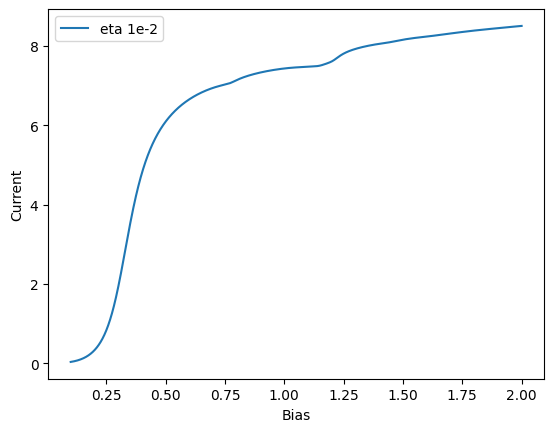

In [90]:
E_shifted = E_dmft - 0.1
np.save("shifted_ET.npy", (E_shifted, T_dmft))
# E_shifted, T_shifted = np.load("shifted_transmission_qtpyt.npy", allow_pickle=True)
I_dmft_shifted, _, _ = current(bias, E_shifted, T_dmft, temperature=temp)
plt.plot(bias,I_dmft_shifted,label="eta 1e-2")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")

### DMFT Spin

/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

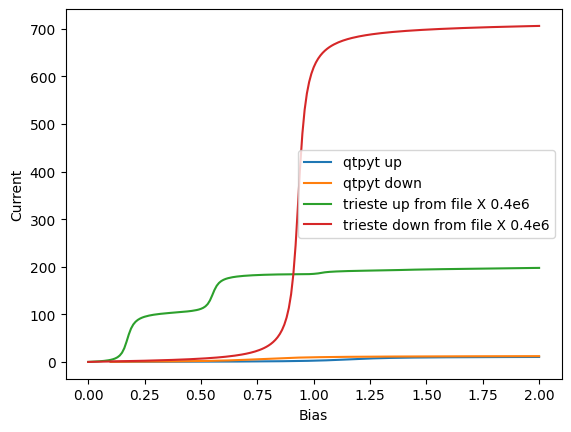

In [82]:
I_qtpyt_dmft_up, _, _ = current(bias, E_dmft, T_dmft_up, temperature=temp)
I_qtpyt_dmft_down, _, _ = current(bias, E_dmft, T_dmft_down, temperature=temp)

plt.plot(bias,I_qtpyt_dmft_up,label="qtpyt up")
plt.plot(bias,I_qtpyt_dmft_down,label="qtpyt down")
plt.plot(I_trieste_dmft[0,:,0],-1*I_trieste_dmft[0,:,1]*0.4*1e6,label="trieste up from file X 0.4e6")
plt.plot(I_trieste_spin[1,:,0],-1*I_trieste_spin[1,:,1]*0.4*1e6,label="trieste down from file X 0.4e6")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
# plt.xlim(0,0.1)
# plt.yscale("log")

coeffs [ 0.6014298  -0.00116037  0.84059278]


/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


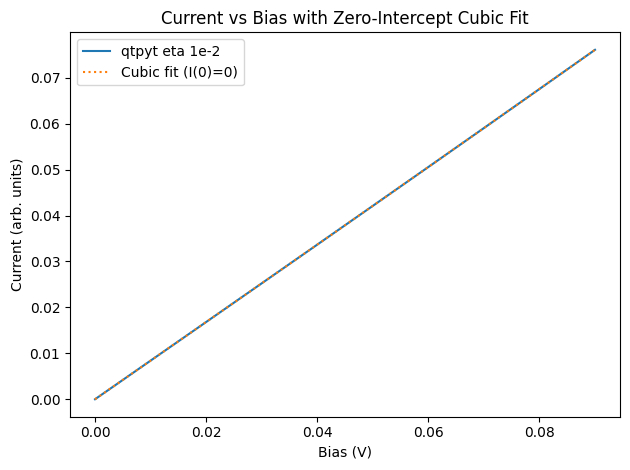

In [83]:
# bias_coeff = np.arange(0.0, 1.25, 0.01) # Region for linear fit
I_dmft_coeff_up, _, _ = current(bias_coeff, E_dmft, T_dmft_up, temperature=temp)

coeffs_cubic_constrained = fit_cubic_zero_intercept(bias_coeff, I_dmft_coeff_up)
print("coeffs",coeffs_cubic_constrained)
I_fit_constrained = bias_coeff**3 * coeffs_cubic_constrained[0] + \
                    bias_coeff**2 * coeffs_cubic_constrained[1] + \
                    bias_coeff    * coeffs_cubic_constrained[2]

plt.plot(bias_coeff, I_dmft_coeff_up, label="qtpyt eta 1e-2")
plt.plot(bias_coeff, I_fit_constrained, ':', label="Cubic fit (I(0)=0)")
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias with Zero-Intercept Cubic Fit")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


coeffs [ 3.65623876 -0.00939992  2.41505422]


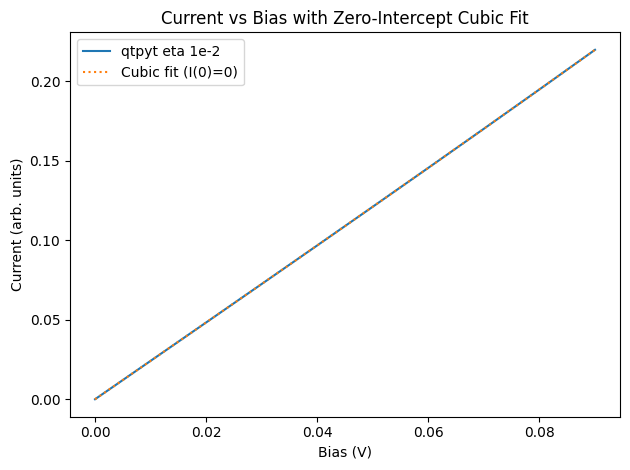

In [84]:
# bias_coeff = np.arange(0.0, 1.25, 0.01) # Region for linear fit
I_dmft_coeff_down, _, _ = current(bias_coeff, E_dmft, T_dmft_down, temperature=temp)

coeffs_cubic_constrained = fit_cubic_zero_intercept(bias_coeff, I_dmft_coeff_down)
print("coeffs",coeffs_cubic_constrained)
I_fit_constrained = bias_coeff**3 * coeffs_cubic_constrained[0] + \
                    bias_coeff**2 * coeffs_cubic_constrained[1] + \
                    bias_coeff    * coeffs_cubic_constrained[2]

plt.plot(bias_coeff, I_dmft_coeff_down, label="qtpyt eta 1e-2")
plt.plot(bias_coeff, I_fit_constrained, ':', label="Cubic fit (I(0)=0)")
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias with Zero-Intercept Cubic Fit")
plt.legend()
plt.tight_layout()
plt.show()


### ED

/tmp/ipykernel_209172/4289149232.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

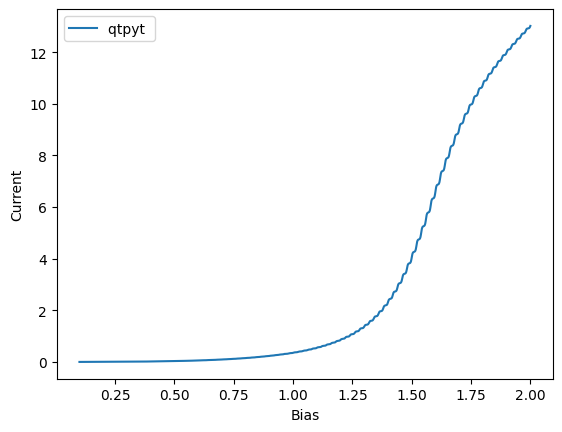

In [85]:
I_qtpyt_ed, _, _ = current(bias, E_ed, T_ed, temperature=temp)
plt.plot(bias,I_qtpyt_ed,label="qtpyt ")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
# plt.xlim(0,0.1)
# plt.yscale("log")

In [91]:
# np.save("./output/lowdin/dft/VI.npy", (bias,I_qtpyt_dft))
# np.save("./output/lowdin/dmft/non_spin/VI.npy", (bias,I_qtpyt_dmft))
np.save("./output/lowdin/dmft/non_spin/shifted_VI.npy", (bias,I_dmft_shifted))
# np.save("./output/lowdin/dmft/spin/VI_up.npy", (bias,I_qtpyt_dmft_up))
# np.save("./output/lowdin/dmft/spin/VI_dw.npy", (bias,I_qtpyt_dmft_down))
# np.save("./output/lowdin/ed/VI.npy", (bias,I_qtpyt_ed))